In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from fbprophet import Prophet

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p My Drive
!google-drive-ocamlfuse My Drive


!ls My Drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > My Drive/created.txt

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [4]:
chicago_df_1 = pd.read_csv('Drive/Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)
chicago_df_2 = pd.read_csv('Drive/Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)
chicago_df_3 = pd.read_csv('Drive/Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [0]:
chicago_df = pd.concat([chicago_df_1, chicago_df_2, chicago_df_3], ignore_index=False, axis=0)

In [6]:
chicago_df

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,1622,16.0,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,321,3.0,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,321,3.0,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,False,1633,16.0,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,5,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,822,8.0,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456709,6250330,10508679,HZ250507,05/03/2016 11:33:00 PM,026XX W 23RD PL,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1034,10.0,28.0,30.0,08B,1159105.0,1888300.0,2016,05/10/2016 03:56:50 PM,41.849222,-87.691556,"(41.849222028, -87.69155551)"
1456710,6251089,10508680,HZ250491,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,731,7.0,17.0,69.0,14,1175230.0,1856183.0,2016,05/10/2016 03:56:50 PM,41.760744,-87.633335,"(41.760743949, -87.63333531)"
1456711,6251349,10508681,HZ250479,05/03/2016 12:15:00 AM,024XX W 63RD ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,825,8.0,15.0,66.0,04B,1161027.0,1862810.0,2016,05/10/2016 03:56:50 PM,41.779235,-87.685207,"(41.779234743, -87.685207125)"
1456712,6253257,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,423,4.0,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"


In [7]:
chicago_df.tail()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1456709,6250330,10508679,HZ250507,05/03/2016 11:33:00 PM,026XX W 23RD PL,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1034,10.0,28.0,30.0,08B,1159105.0,1888300.0,2016,05/10/2016 03:56:50 PM,41.849222,-87.691556,"(41.849222028, -87.69155551)"
1456710,6251089,10508680,HZ250491,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,731,7.0,17.0,69.0,14,1175230.0,1856183.0,2016,05/10/2016 03:56:50 PM,41.760744,-87.633335,"(41.760743949, -87.63333531)"
1456711,6251349,10508681,HZ250479,05/03/2016 12:15:00 AM,024XX W 63RD ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,825,8.0,15.0,66.0,04B,1161027.0,1862810.0,2016,05/10/2016 03:56:50 PM,41.779235,-87.685207,"(41.779234743, -87.685207125)"
1456712,6253257,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,423,4.0,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"
1456713,6253474,10508692,HZ250517,05/03/2016 11:38:00 PM,001XX E 75TH ST,5007,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,False,323,3.0,6.0,69.0,26,1178696.0,1855324.0,2016,05/10/2016 03:56:50 PM,41.758309,-87.620658,"(41.75830866, -87.620658418)"


In [8]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6017767 entries, 0 to 1456713
Data columns (total 23 columns):
Unnamed: 0              int64
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(4), object(10)
memory usage: 1021.5+ MB


In [9]:
chicago_df.isnull().sum()

Unnamed: 0                  0
ID                          0
Case Number                 7
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     1974
Arrest                      0
Domestic                    0
Beat                        0
District                   89
Ward                       92
Community Area           1844
FBI Code                    0
X Coordinate            74882
Y Coordinate            74882
Year                        0
Updated On                  0
Latitude                74882
Longitude               74882
Location                74882
dtype: int64

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


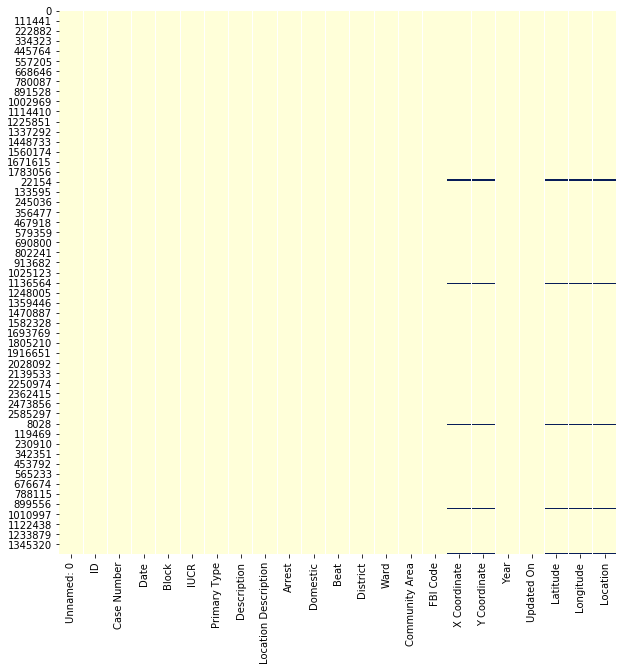

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(chicago_df.isnull(), cbar = False, cmap = 'YlGnBu')

In [0]:
chicago_df.drop(['Unnamed: 0', 'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'], inplace=True, axis=1)

In [12]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
3,4673629,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
4,4673630,02/17/2006 09:03:14 PM,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False
...,...,...,...,...,...,...,...,...
1456709,10508679,05/03/2016 11:33:00 PM,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
1456710,10508680,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
1456711,10508681,05/03/2016 12:15:00 AM,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False
1456712,10508690,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True


In [0]:
# setting the index to be the date 
chicago_df.index = pd.DatetimeIndex(chicago_df.Date)


In [14]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,,
2006-04-02 13:00:00,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
2006-02-26 13:40:48,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2006-01-08 23:16:00,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
2006-04-05 18:45:00,4673629,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
2006-02-17 21:03:14,4673630,02/17/2006 09:03:14 PM,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False
...,...,...,...,...,...,...,...,...
2016-05-03 23:33:00,10508679,05/03/2016 11:33:00 PM,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
2016-05-03 23:30:00,10508680,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
2016-05-03 00:15:00,10508681,05/03/2016 12:15:00 AM,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False


In [15]:
chicago_df['Primary Type'].value_counts()

THEFT                                1245111
BATTERY                              1079178
CRIMINAL DAMAGE                       702702
NARCOTICS                             674831
BURGLARY                              369056
OTHER OFFENSE                         368169
ASSAULT                               360244
MOTOR VEHICLE THEFT                   271624
ROBBERY                               229467
DECEPTIVE PRACTICE                    225180
CRIMINAL TRESPASS                     171596
PROSTITUTION                           60735
WEAPONS VIOLATION                      60335
PUBLIC PEACE VIOLATION                 48403
OFFENSE INVOLVING CHILDREN             40260
CRIM SEXUAL ASSAULT                    22789
SEX OFFENSE                            20172
GAMBLING                               14755
INTERFERENCE WITH PUBLIC OFFICER       14009
LIQUOR LAW VIOLATION                   12129
ARSON                                   9269
HOMICIDE                                5879
KIDNAPPING

In [16]:
chicago_df['Primary Type'].value_counts().iloc[:15].index

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'OTHER OFFENSE', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'PROSTITUTION',
       'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION',
       'OFFENSE INVOLVING CHILDREN'],
      dtype='object')

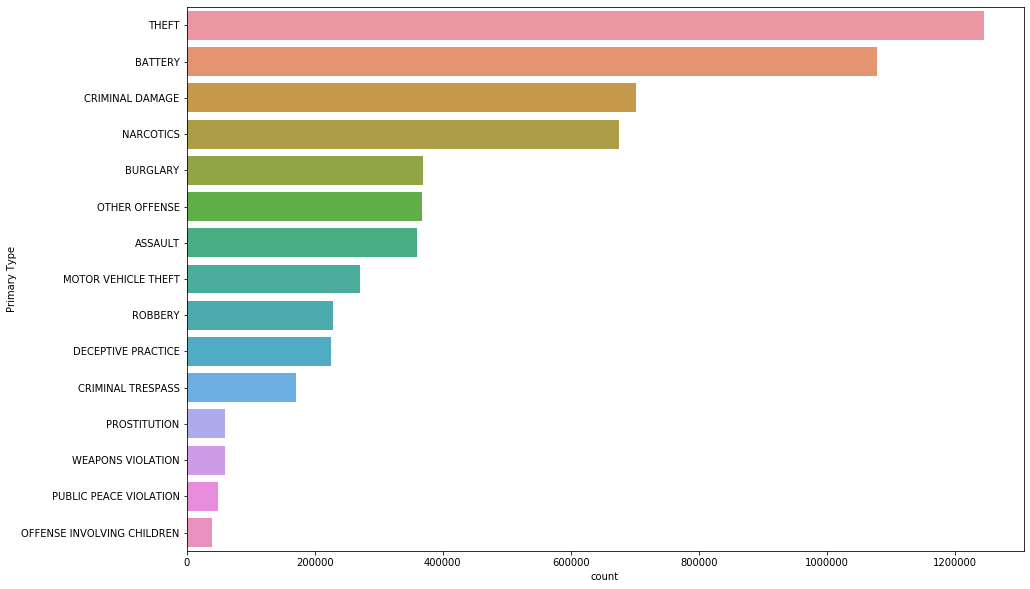

In [17]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Primary Type', data = chicago_df, order = chicago_df['Primary Type'].value_counts().iloc[:15].index)

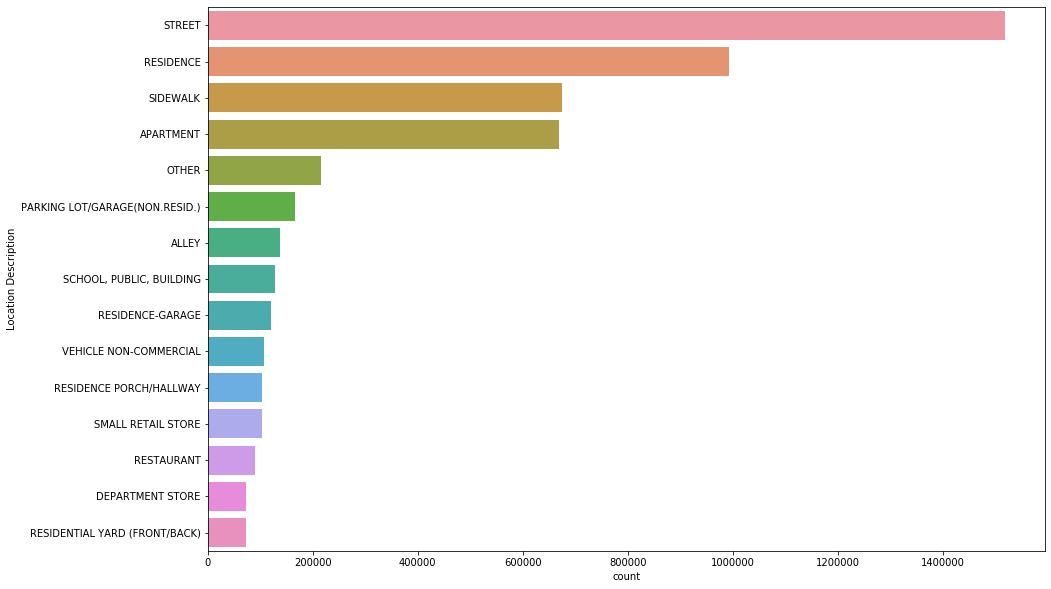

In [18]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Location Description', data = chicago_df, order = chicago_df['Location Description'].value_counts().iloc[:15].index)

In [19]:
chicago_df.resample('Y').size()

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of Crimes')

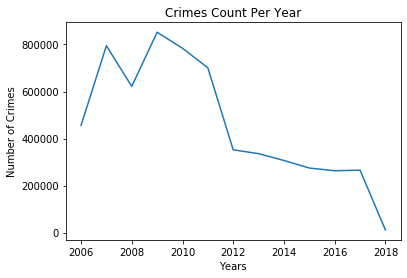

In [20]:
plt.plot(chicago_df.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

In [21]:
chicago_df.resample('M').size()

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 145, dtype: int64

Text(0, 0.5, 'Number of Crimes')

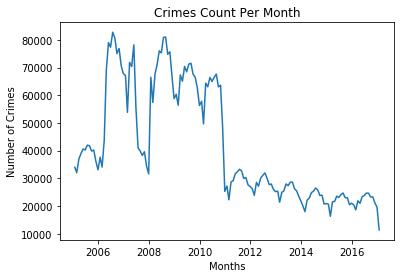

In [22]:
plt.plot(chicago_df.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')

In [23]:
chicago_df.resample('Q').size()

Date
2005-03-31    102995
2005-06-30    119769
2005-09-30    123550
2005-12-31    109497
2006-03-31    115389
2006-06-30    225489
2006-09-30    238423
2006-12-31    215383
2007-03-31    192791
2007-06-30    204361
2007-09-30    119086
2007-12-31    105610
2008-03-31    191523
2008-06-30    222331
2008-09-30    236695
2008-12-31    201504
2009-03-31    184055
2009-06-30    203916
2009-09-30    210446
2009-12-31    185483
2010-03-31    171848
2010-06-30    194453
2010-09-30    197116
2010-12-31    137274
2011-03-31     78167
2011-06-30     93064
2011-09-30     95835
2011-12-31     85000
2012-03-31     78574
2012-06-30     88283
2012-09-30     89685
2012-12-31     79128
2013-03-31     71651
2013-06-30     80776
2013-09-30     83510
2013-12-31     70766
2014-03-31     59964
2014-06-30     72991
2014-09-30     76090
2014-12-31     65482
2015-03-31     58503
2015-06-30     68239
2015-09-30     71782
2015-12-31     64471
2016-03-31     60843
2016-06-30     68085
2016-09-30     72500
2016-12-

Text(0, 0.5, 'Number of Crimes')

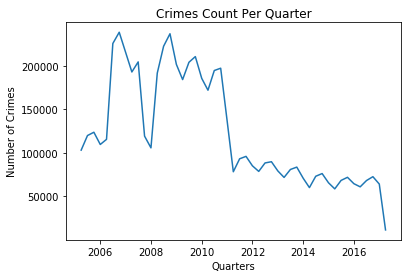

In [24]:
plt.plot(chicago_df.resample('Q').size())
plt.title('Crimes Count Per Quarter')
plt.xlabel('Quarters')
plt.ylabel('Number of Crimes')

In [0]:
chicago_prophet = chicago_df.resample('M').size().reset_index()

In [26]:
chicago_prophet

,Date,0
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


In [0]:
chicago_prophet.columns = ['Date', 'Crime Count']

In [28]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,,
2006-04-02 13:00:00,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
2006-02-26 13:40:48,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2006-01-08 23:16:00,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
2006-04-05 18:45:00,4673629,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
2006-02-17 21:03:14,4673630,02/17/2006 09:03:14 PM,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False
...,...,...,...,...,...,...,...,...
2016-05-03 23:33:00,10508679,05/03/2016 11:33:00 PM,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
2016-05-03 23:30:00,10508680,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
2016-05-03 00:15:00,10508681,05/03/2016 12:15:00 AM,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False


In [0]:
chicago_prophet_df = pd.DataFrame(chicago_prophet)

In [30]:
chicago_prophet_df

,Date,Crime Count
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


In [31]:
chicago_prophet_df.columns

Index(['Date', 'Crime Count'], dtype='object')

In [0]:
chicago_prophet_df_final = chicago_prophet_df.rename(columns={'Date':'ds', 'Crime Count':'y'})


In [33]:
chicago_prophet_df_final

,ds,y
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


In [35]:
m=Prophet()
m.fit(chicago_prophet_df_final)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [37]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-31,60454.736755,40173.061032,73478.842616,60454.736755,60454.736755,-4762.400048,-4762.400048,-4762.400048,-4762.400048,-4762.400048,-4762.400048,0.0,0.0,0.0,55692.336707
1,2005-02-28,60322.333828,34739.576195,67012.866019,60322.333828,60322.333828,-9500.508891,-9500.508891,-9500.508891,-9500.508891,-9500.508891,-9500.508891,0.0,0.0,0.0,50821.824937
2,2005-03-31,60175.744873,41172.579265,74963.970812,60175.744873,60175.744873,-1224.148242,-1224.148242,-1224.148242,-1224.148242,-1224.148242,-1224.148242,0.0,0.0,0.0,58951.596630
3,2005-04-30,60033.884593,44343.043552,77910.103291,60033.884593,60033.884593,1182.830385,1182.830385,1182.830385,1182.830385,1182.830385,1182.830385,0.0,0.0,0.0,61216.714978
4,2005-05-31,59887.295638,48645.308307,82386.624637,59887.295638,59887.295638,5498.250108,5498.250108,5498.250108,5498.250108,5498.250108,5498.250108,0.0,0.0,0.0,65385.545746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2018-01-27,10104.041516,-12582.710133,22442.504734,9942.465471,10270.745700,-4977.963003,-4977.963003,-4977.963003,-4977.963003,-4977.963003,-4977.963003,0.0,0.0,0.0,5126.078513
506,2018-01-28,10090.974833,-11688.758152,21577.418043,9929.336848,10257.912547,-4922.604059,-4922.604059,-4922.604059,-4922.604059,-4922.604059,-4922.604059,0.0,0.0,0.0,5168.370774
507,2018-01-29,10077.908150,-11307.981588,22624.175715,9915.797415,10245.750154,-4867.916431,-4867.916431,-4867.916431,-4867.916431,-4867.916431,-4867.916431,0.0,0.0,0.0,5209.991719
508,2018-01-30,10064.841467,-11305.224548,21635.705398,9901.911196,10233.581910,-4816.731916,-4816.731916,-4816.731916,-4816.731916,-4816.731916,-4816.731916,0.0,0.0,0.0,5248.109550


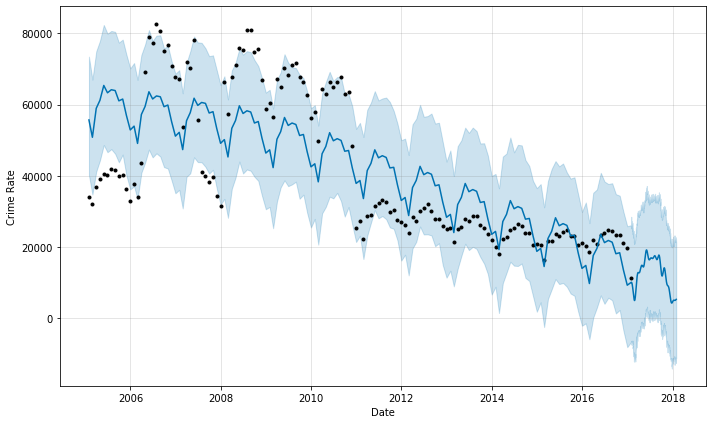

In [38]:
figure = m.plot(forecast, xlabel='Date', ylabel='Crime Rate')

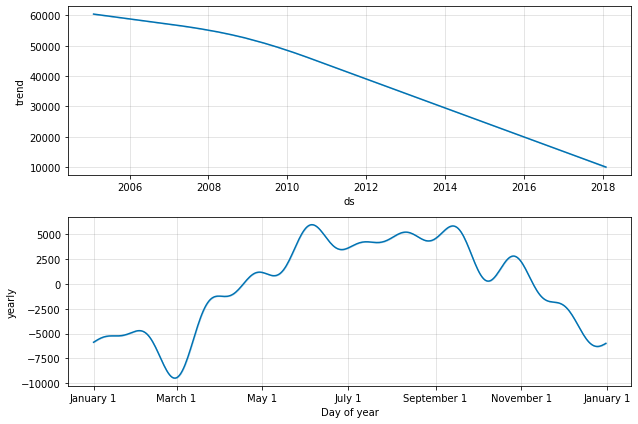

In [39]:
figure3 = m.plot_components(forecast)